In [1]:
import os
os.chdir("../src")
import glasgow_behavior
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import ptitprince as pt
import statsmodels.stats.multicomp as mc
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import ptitprince as pt
import statsmodels.stats.multicomp as mc
from scipy import stats

from matplotlib.patches import Rectangle
from matplotlib.patches import Patch

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels, size):
            self.set_thetagrids(np.degrees(theta), labels, size=size)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def radar_plot(ax, d, title, theta, spoke_labels, thresholds=None, colors=None):
    ax.set_rgrids([])
    ax.set_title(title, size=13, position=(0.5, 1), y=1.15,
                    horizontalalignment='center', verticalalignment='center')
    #Zero line
    ax.plot(theta, np.zeros(len(d)), color='grey', lw=1.8)
    ax.plot(theta, d, color='black', lw=2.5)

    ax.set_varlabels(spoke_labels, 10.5)
    ax.set_ylim(-0.5,0.5)

    a = ax.get_xgridlines()

    if thresholds != None:
        if colors == None:
            print("WARNING: Threshold colors not supplied!")
            return ax
        i = 0
        ti = 0
        t = 0
        for line in a:
            if i > (t-1):
                t = thresholds[ti]
                c = colors[ti]
                ti += 1
            line.set_color(c) 
            i+=1
    return ax

def rain_plot(ax, df, cPalette, order, dx, dy, compute_stats=False, stat_start=[-5,24], stat_gap=1.8):

    ort = "h"; sigma = .5; cut=1.7; move=0.2; linewidth=2; 
    scale=0.85; pointplot=False

    ax=pt.RainCloud(x = dx, y = dy, data = df, palette = cPalette, bw = sigma, cut=cut, order=order, pointplot=pointplot,
                        width_viol = scale, ax = ax, orient = ort, move = move, scale="width", linewidth = linewidth, linecolor="red")

    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.spines.bottom.set(linewidth=6)

    if compute_stats:
        #data without PTT
        stat_df = df[df[dx] != "PTT"]

        #compute stats
        comp1 = mc.MultiComparison(stat_df[dy], stat_df[dx])
        tbl, a1, a2 = comp1.allpairtest(stats.ttest_ind, method= "bonf")

        #ANOVA
        all_data = []
        for group in order:
            all_data.append(stat_df[stat_df[dx] == group][dy].to_numpy())
        f, p = f_oneway(*all_data)

        ax.set_title(f'{dy}\n F={round(f,3)}, p={round(p,3)}')

        #stat bars
        #first row is column names

        loc = {}
        switch = False
        for row in tbl.data[1:]:
            if row[5]:
                g1 = row[0]
                g2 = row[1]
                if g1 == order[-1] or g2 == order[-1]:
                    right = False
                else:
                    right = True
                t = row[2]
                p = row[4]

                g1_i = order.index(g1)
                g2_i = order.index(g2)
                bottom = min(g1_i, g2_i)
                top = max(g1_i, g2_i)

                #length controls line plot x location
                length = abs(g2_i-g1_i)
                gap = stat_gap
                x_dist_iter = length
                x_dist = gap
                br_length =0.75
                

                while x_dist_iter -1 > 0:
                    x_dist_iter -=1
                    x_dist += x_dist_iter + gap

                if right:
                    x_pos = x_dist + stat_start[1] + ((top - length) %length)
                    br_length = -br_length
                    text_offset = 0.8
                else:
                    x_pos = -x_dist + stat_start[0] - ((top - length) %length)
                    text_offset = -2.3
                    
                y_offset = -move
                y_scale = 1
                y_gap = 0.09

                

                #vertical line
                ax.plot([x_pos, x_pos], [y_scale*bottom+y_gap + y_offset, y_scale*top-y_gap + y_offset], lw=1.4, color='black', marker='', zorder=4, clip_on=False)
                y_top = y_scale*top-y_gap + y_offset
                y_bottom = y_scale*bottom+y_gap + y_offset
                sig = "ERROR"
                if p < 0.05:
                    if p < 0.01:
                        if p < 0.001:
                            sig = "***"
                        else:
                            sig = "**"
                    else:
                        sig = "*"

                ax.text(x_pos + text_offset, y_bottom + (y_top-y_bottom)/2, sig,rotation=90, clip_on=False, backgroundcolor='white', zorder=2, color='black', va='center')
                #horizontal bars
                ax.plot([x_pos, x_pos+br_length], [y_scale*top-y_gap + y_offset, y_scale*top-y_gap + y_offset], lw=1.4, color='black', marker='', zorder=4, clip_on=False)
                ax.plot([x_pos, x_pos+br_length], [y_scale*bottom+y_gap + y_offset, y_scale*bottom+y_gap + y_offset], lw=1.4, color='black', marker='', zorder=4, clip_on=False)
    return ax

def correlation_plot(fig, ax, df):
    corr_data = df.to_numpy()
    i = 0
    for x in range(len(corr_data)):
        for y in range(len(corr_data)):
            if y > i:
                corr_data[x][y] = 0
        i += 1

    im = ax.imshow(corr_data, cmap="bwr")
    im.set_clim(-1,1)
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #BACS-CAARMS lines
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[0]+8], [ax.get_ylim()[1]+8, ax.get_ylim()[1]+8], lw=.8, color='black', marker='', zorder=4)
    ax.plot([ax.get_xlim()[0]+8, ax.get_xlim()[0]+8], [ax.get_ylim()[0], ax.get_ylim()[1]+8], lw=.8, color='black', marker='', zorder=4)

    #CAARMS-SPIA lines
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[0]+13], [ax.get_ylim()[1]+13, ax.get_ylim()[1]+13], lw=.8, color='black', marker='', zorder=4)
    ax.plot([ax.get_xlim()[0]+13, ax.get_xlim()[0]+13], [ax.get_ylim()[0], ax.get_ylim()[1]+13], lw=.8, color='black', marker='', zorder=4)

    #Legend bars y axis
    ax.add_patch(Rectangle((ax.get_xlim()[0]-1, ax.get_ylim()[1]), 1,8, facecolor = 'fuchsia', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]-1, ax.get_ylim()[1]+8), 1,5.1, facecolor = 'forestgreen', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]-1, ax.get_ylim()[1]+13.1), 1,14, facecolor = 'orange', clip_on=False))

    #Legend bars x axis
    ax.add_patch(Rectangle((ax.get_xlim()[0], ax.get_ylim()[0]), 8,1, facecolor = '#FF00FF', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]+8, ax.get_ylim()[0]), 5.1,1, facecolor = '#176423', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]+13.1, ax.get_ylim()[0]), 14,1, facecolor = '#ff9402', clip_on=False))

    #Hide the diagonal data
    ax.add_patch(Rectangle((ax.get_xlim()[0], ax.get_ylim()[1]-1.5), 40,1, facecolor = 'white', angle=45, clip_on=False))

    legend_elements = [Patch(facecolor='#FF00FF', label='BACS (1-8)'),
                    Patch(facecolor='#176423', label='CAARMS (9-13)'),
                    Patch(facecolor='#ff9402', label='SPIA (14-27)')]

    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, bbox_to_anchor=(1.05,1), frameon=False)
    plt.colorbar(im, ax=ax, shrink=0.28, aspect=7, pad=-0.15)


In [2]:
df = pd.read_csv('../data/behavior_followup_ALL.tsv', sep='\t')
id_df = pd.read_csv('../csvs/YouR_Study_All_Misc.csv')[['Study_ID','Scan_ID']].rename(columns={'Scan_ID':'participant_id'})
caarms_12month = pd.read_csv('../csvs/CAARMS_12months.csv')
groups_12month = caarms_12month[['Study_ID', 'CAARMS_Group_12months']]
arms_df = pd.read_csv('../csvs/CAARMS_baseline.csv')[['Study_ID', 'CAARMS_group_baseline_final_score']]
mapper_arms = {'0':'None','1':'Attenuated Psychosis Group','3':'Vulnerability Group','4':'Psychosis Threshold', '5':'Attenuated Psychosis + Vulnerability'}
arms_df['CAARMS_group_baseline_final_score'] = arms_df['CAARMS_group_baseline_final_score'].map(mapper_arms)
groups_12month['CAARMS_Group_12months'] = groups_12month['CAARMS_Group_12months'].map(mapper_arms)

merged_df = id_df.merge(arms_df, how='left', on='Study_ID').merge(groups_12month, how='left', on='Study_ID')
merged_df = merged_df.drop(columns='Study_ID')
merged_df = df.merge(merged_df, how='left', on='participant_id')

group_baseline = merged_df['CAARMS_group_baseline_final_score'].to_list()
group_followup = merged_df['CAARMS_Group_12months'].to_list()
group_transition = []
rank_transition = []

for base, followup in zip(group_baseline, group_followup):
    group_transition.append(f"{base}>{followup}")
    if base == "None" and followup == "None":
        rank_transition.append("None")
    elif base == "None":
        rank_transition.append("Transition to AP")
    elif followup == "None":
        rank_transition.append("Transition to None")
    elif base == followup:
        rank_transition.append("Remain AP")
    else:
        rank_transition.append("AP to Psychosis Threshold")

merged_df['CAARMS_group_transition'] = group_transition
merged_df['CAARMS_group_transition_type'] = rank_transition

scores = pd.read_csv('/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_convert_ALL_n192/analysis/results/NBRIDGE_Glasgow.collaboration_convert_ALL_n192_BehaviorPCAScores.tsv', sep='\t')
scores[['PC1','PC2']] = scores[['PC1','PC2']] *-1
merged_df = merged_df.merge(scores[['participant_id', 'PC1', 'PC2', 'PC3']], 'left', 'participant_id')

c_comp_cols = ['CAARMS_UTC_severity','CAARMS_NBI_severity', 'CAARMS_PA_severity', 'CAARMS_DS_severity']
merged_df['CAARMS Composite'] = merged_df[c_comp_cols].sum(axis=1).to_numpy()

merged_df['SPIA Composite'] = merged_df.filter(regex='SPIA').sum(axis=1)

/var/folders/_f/51yc4jgj2yb300z_hgqpzxq59rm7sh/T/ipykernel_74916/2274827522.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groups_12month['CAARMS_Group_12months'] = groups_12month['CAARMS_Group_12months'].map(mapper_arms)


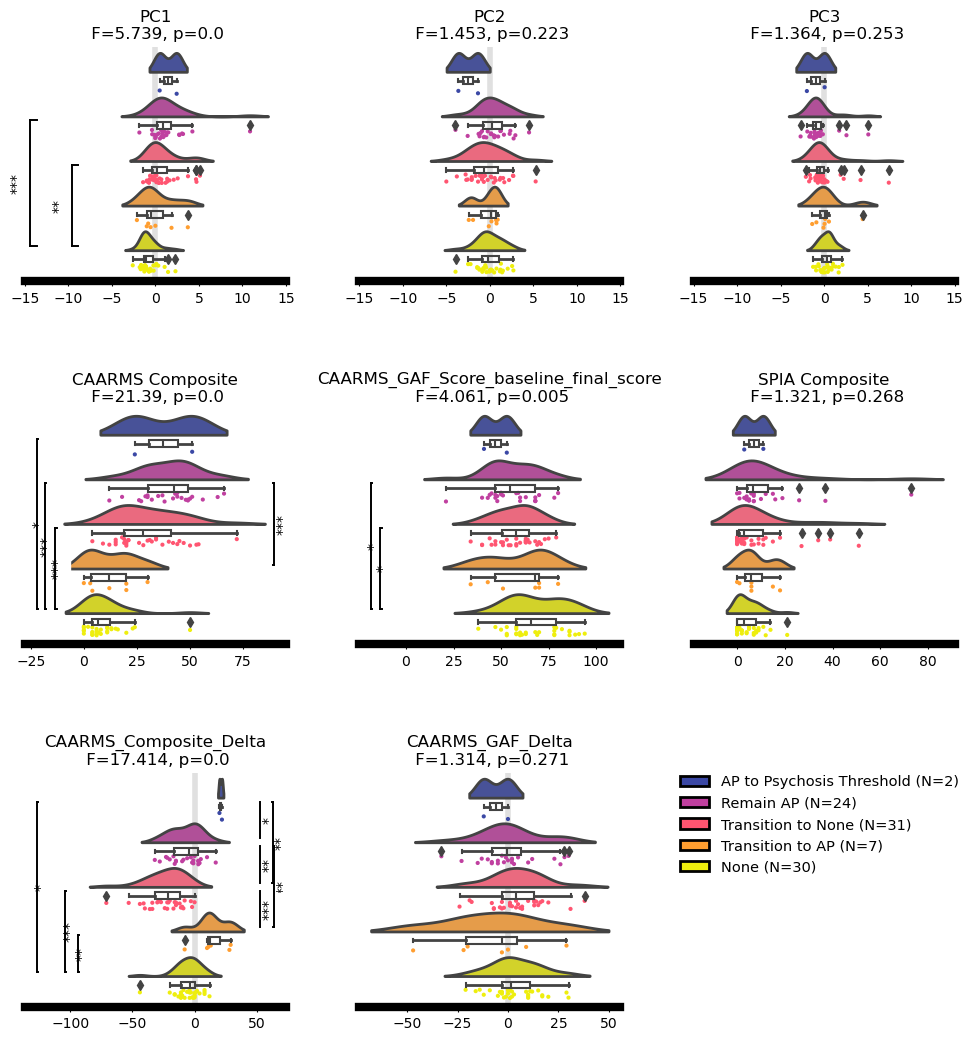

In [3]:
fig = plt.figure(figsize=(12,12))
spec = fig.add_gridspec(ncols=3,nrows=3)
fig.subplots_adjust(wspace=0.28, hspace=0.55, top=0.85, bottom=0.05)

arms_order = ['None', 'Transition to AP', 'Transition to None', 'Remain AP', 'AP to Psychosis Threshold']
arms_order.reverse()
arms_cDict = {'None':"#eeee0e",
                 'Transition to AP':"#ff9e30",
                 'Transition to None':"#ff5571",
                 'Remain AP':"#c040a0",
                 'AP to Psychosis Threshold':"#3b48a5"}

counts_df = merged_df["CAARMS_group_transition_type"].value_counts()
counts = []
legendLabels = []
arms_cPalette = []
for group in arms_order:
    counts.append(counts_df[group])
    legendLabels.append(f'{group} (N={counts_df[group]})')
    arms_cPalette.append(arms_cDict[group])

for i, var in enumerate(['PC1', 'PC2', 'PC3']):
    ax_rain = fig.add_subplot(spec[0,i])
    ax_rain.plot([0,0],[-20,20], zorder=0, color='lightgrey', lw=4, alpha=0.7)
    ax_rain = rain_plot(ax_rain, merged_df, arms_cPalette, arms_order, 'CAARMS_group_transition_type', var, True)
    ax_rain.set_xlim((-15,15))
    ax_rain.set(yticklabels=[])
    ax_rain.tick_params(left=False)

for i, var in enumerate(['CAARMS Composite', 'CAARMS_GAF_Score_baseline_final_score', 'SPIA Composite']):
    ax_rain = fig.add_subplot(spec[1,i])
    #ax_rain.plot([0,0],[-20,20], zorder=0, color='lightgrey', lw=4, alpha=0.7)
    ax_rain = rain_plot(ax_rain, merged_df, arms_cPalette, arms_order, 'CAARMS_group_transition_type', var, True, stat_start=[-9,84])
    #ax_rain.set_title(var)
    #ax_rain.set_xlim((-15,15))
    ax_rain.set(yticklabels=[])
    ax_rain.tick_params(left=False)

for i, var in enumerate(['CAARMS_Composite_Delta', 'CAARMS_GAF_Delta',]):
    ax_rain = fig.add_subplot(spec[2,i])
    ax_rain.plot([0,0],[-20,20], zorder=0, color='lightgrey', lw=4, alpha=0.7)
    ax_rain = rain_plot(ax_rain, merged_df, arms_cPalette, arms_order, 'CAARMS_group_transition_type', var, True, stat_start=[-85,44], stat_gap=9)
    #ax_rain.set_title(var)
    #ax_rain.set_xlim((-15,15))
    ax_rain.set(yticklabels=[])
    ax_rain.tick_params(left=False)

legend_elements = []
#legendLabels.reverse()
for i in range(len(legendLabels)):
    legend_elements.append(Patch(facecolor=arms_cPalette[i], edgecolor='black', linewidth=2, label=legendLabels[i]))

fig.legend(handles=legend_elements, loc="lower left", bbox_to_anchor=(0.66,0.15), frameon=False, prop={'size': 10.5})

In [2]:
df = pd.read_csv('../data/caarms_followup_all_more.tsv', sep='\t')
id_df = pd.read_csv('../csvs/YouR_Study_All_Misc.csv')[['Study_ID','Scan_ID']].rename(columns={'Scan_ID':'participant_id'})
mapper_arms = {'0':'None','1':'Attenuated Psychosis Group','3':'Vulnerability Group','4':'Psychosis Threshold', '5':'Attenuated Psychosis + Vulnerability'}

date_df = pd.read_csv(f'../csvs/CAARMS_baseline.csv')[['Study_ID', 'CAARMS_group_baseline_final_score']]
date_df['CAARMS_group_baseline_final_score'] = date_df['CAARMS_group_baseline_final_score'].map(mapper_arms)
date_df = date_df.rename(columns={'CAARMS_group_baseline_final_score': 'CAARMS_Group_baseline'})

merged_df = id_df.merge(date_df, how='left', on='Study_ID')

for date in df['date'].unique():
    if date != 'baseline':
        date_df = pd.read_csv(f'../csvs/CAARMS_{date}.csv')[['Study_ID', f'CAARMS_Group_{date}']]
        date_df[f'CAARMS_Group_{date}'] = date_df[f'CAARMS_Group_{date}'].map(mapper_arms)
        merged_df = merged_df.merge(date_df, how='left', on='Study_ID')

QC_df =  pd.read_csv('../data/behavior_convert_ALL.tsv', sep = '\t')[['participant_id','Group']]
#QC_ids = QC_df['participant_id'].to_list()
#merged_df = merged_df[merged_df['participant_id'].isin(QC_ids)].reset_index()
merged_df = QC_df.merge(merged_df, how='left', on='participant_id').reset_index()
#merged

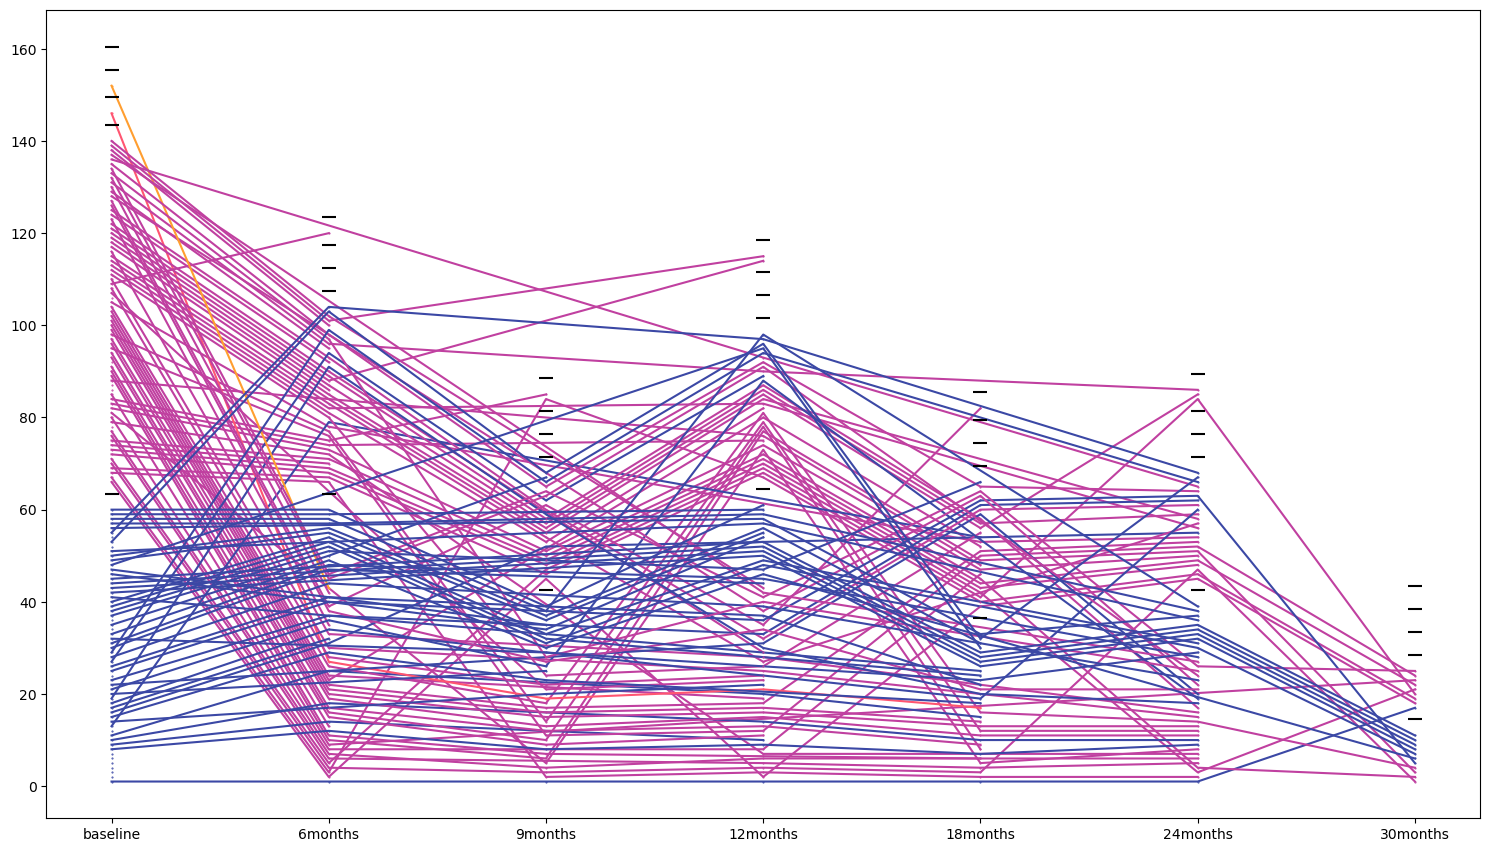

In [5]:
from matplotlib.collections import LineCollection
import warnings

merged_df = merged_df[(merged_df['Group'] != 'Control') & (merged_df['Group'] != 'First Episode Psychosis')].reset_index()

dates = ['baseline', '6months', '9months', '12months', '18months', '24months', '30months']
arms_order = ['None', 'Attenuated Psychosis Group', 'Vulnerability Group', 'Attenuated Psychosis + Vulnerability', 'Psychosis Threshold']
arms_cDict = {'None':"#eeee0e",
                 'Attenuated Psychosis Group':"#ff9e30",
                 'Vulnerability Group':"#ff5571",
                 'Attenuated Psychosis + Vulnerability':"#c040a0",
                 'Psychosis Threshold':"#3b48a5"}

arms_cPalette = [arms_cDict[a] for a in arms_order]

#Stores line at each index in the dataframe
line_arr = np.zeros((2, merged_df.shape[0], len(dates), 2), dtype=np.int32)
#Indices where group changes
cat_list = []

gap = 5

d_i = 0
first = True
for date in dates:
    end_list = []
    start_i = 1
    a_i = 1
    for arms in arms_order:
        ind = merged_df[merged_df[f'CAARMS_Group_{date}'] == arms].index
        end_i = start_i + len(ind)
        end_list.append([d_i, end_i+gap/2])
        line_arr[0,ind,d_i,0] = np.arange(start_i, end_i)
        line_arr[0,ind,d_i,1] = d_i
        line_arr[1,ind,d_i] = a_i
        start_i = end_i + gap
        a_i += 1
    cat_list.append(end_list)
    d_i+=1
    first = False

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
#plot = fig.add_subplot(spec[0,0])
arms_order.reverse()
for row in range(len(line_arr[0])):
    scrubbed = [ele for ele in line_arr[0][row] if ele[0] != 0]
    scrubbed_c = [arms_cDict[arms_order[ele[0]-1]] for ele in line_arr[1][row] if ele[0] != 0]
    if len(scrubbed) != 0:
        line = np.vstack(scrubbed)
        ax.plot(line[:,1], line[:,0], color=scrubbed_c[0], zorder=0)
        ax.scatter(line[:,1], line[:,0], color=scrubbed_c[0], s=1, marker='.')
        #print(line[:,1])
        #print(line[:,0])
        #print(scrubbed_c)
        #print("")
        #ax.scatter(line[:,1], line[:,0], c=scrubbed_c, cmap='rainbow')
        #colored_line(line[:,1], line[:,0], c=scrubbed_c, ax=ax, cmap='rainbow')

for row in cat_list:
    for col in row:
        ax.scatter(col[0],col[1], color='black', s=100, marker="_")

ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(dates)
#for col in merged_df.columns:
        # v_dict = merged_df[f'CAARMS_Group_{date}'].value_counts()
        # s_i = 0
        # for arms in arms_order:
        #     np.arange(s_i, v_dict[arms])
        #     s_i += v_dict[arms]

plt.show()


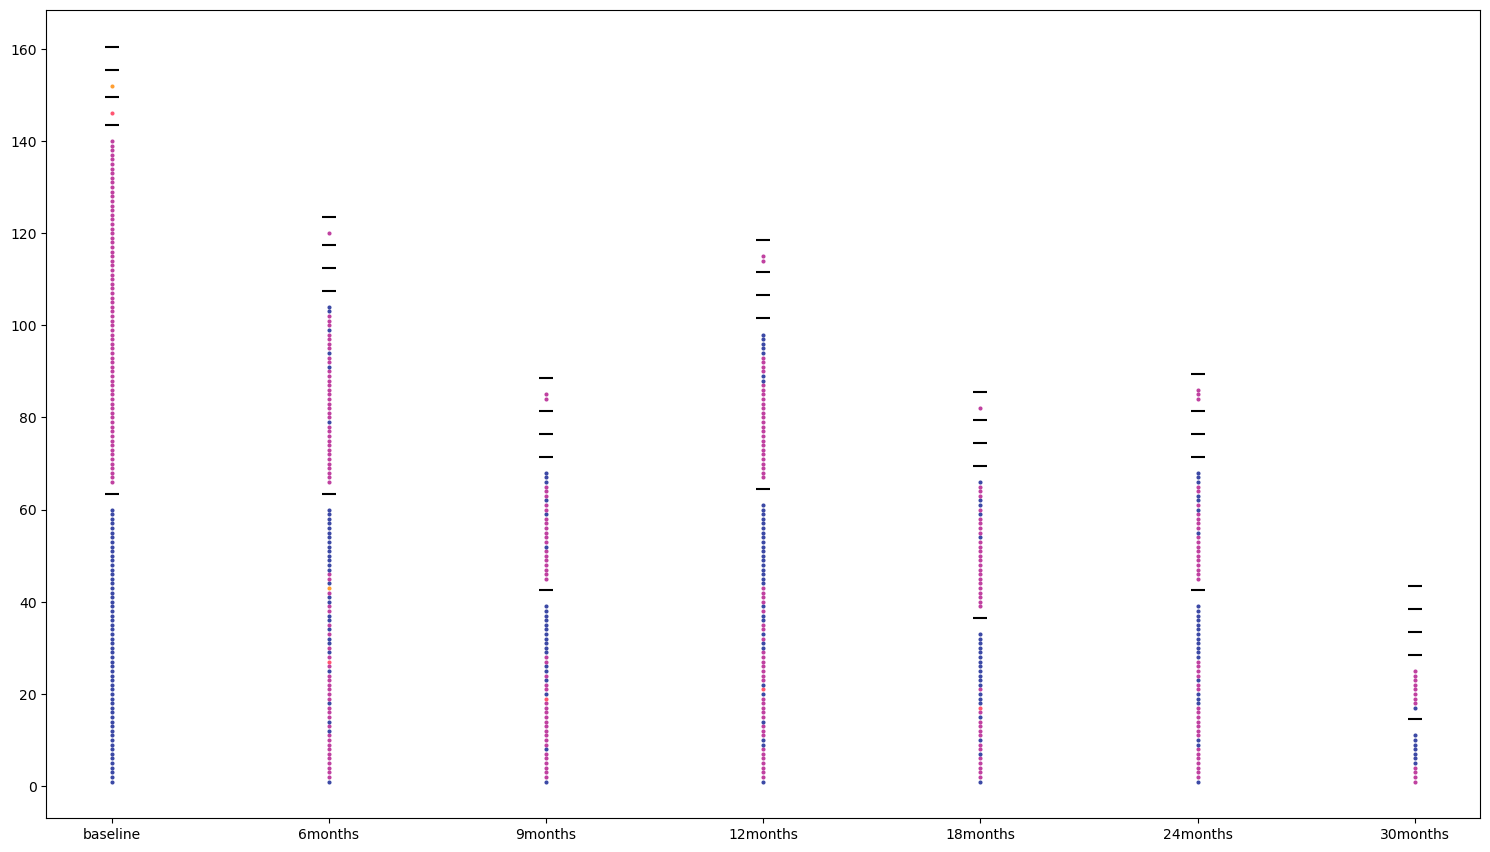

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
#plot = fig.add_subplot(spec[0,0])
for row in range(len(line_arr[0])):
    scrubbed = [ele for ele in line_arr[0][row] if ele[0] != 0]
    scrubbed_c = [arms_cDict[arms_order[ele[0]-1]] for ele in line_arr[1][row] if ele[0] != 0]
    if len(scrubbed) != 0:
        line = np.vstack(scrubbed)
        #ax.plot(line[:,1], line[:,0], color=scrubbed_c[0], zorder=0)
        ax.scatter(line[:,1], line[:,0], color=scrubbed_c[0], s=15, marker='.')
        #print(line[:,1])
        #print(line[:,0])
        #print(scrubbed_c)
        #print("")
        #ax.scatter(line[:,1], line[:,0], c=scrubbed_c, cmap='rainbow')
        #colored_line(line[:,1], line[:,0], c=scrubbed_c, ax=ax, cmap='rainbow')

for row in cat_list:
    for col in row:
        ax.scatter(col[0],col[1], color='black', s=100, marker="_")

#for col in merged_df.columns:
        # v_dict = merged_df[f'CAARMS_Group_{date}'].value_counts()
        # s_i = 0
        # for arms in arms_order:
        #     np.arange(s_i, v_dict[arms])
        #     s_i += v_dict[arms]
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(dates)
plt.show()

In [3]:
merged_df

,index,participant_id,Group,Study_ID,CAARMS_Group_baseline,CAARMS_Group_6months,CAARMS_Group_9months,CAARMS_Group_12months,CAARMS_Group_18months,CAARMS_Group_24months,CAARMS_Group_30months
0,0,BDA15,Clinical High Risk - Positive,EA001,None,None,None,None,None,None,Attenuated Psychosis Group
1,1,CMH10,Clinical High Risk - Positive,EA003,Attenuated Psychosis Group,None,Attenuated Psychosis Group,None,Attenuated Psychosis Group,Attenuated Psychosis Group,Attenuated Psychosis Group
2,2,APS28,Transition to FEP,EA005,Attenuated Psychosis Group,None,Psychosis Threshold,Attenuated Psychosis Group,Attenuated Psychosis Group,Attenuated Psychosis Group,Attenuated Psychosis Group
3,3,JSA14,Clinical High Risk - Positive,EA007,Attenuated Psychosis Group,Attenuated Psychosis Group,None,None,None,None,NaN
4,4,HSS25,Transition to FEP,EA008,Attenuated Psychosis Group,Attenuated Psychosis Group,Attenuated Psychosis Group,Attenuated Psychosis Group,Attenuated Psychosis Group,Psychosis Threshold,Attenuated Psychosis Group
...,...,...,...,...,...,...,...,...,...,...,...
187,187,LTE22,Clinical High Risk - Negative,GL037,None,NaN,NaN,None,None,None,NaN
188,188,JBR31,Clinical High Risk - Negative,GL038,None,None,NaN,None,NaN,None,NaN
189,189,CBA31,Clinical High Risk - Negative,GL042,None,None,None,Attenuated Psychosis Group,NaN,None,NaN
190,190,BWH17,Clinical High Risk - Negative,GL043,None,None,NaN,None,NaN,NaN,NaN


In [15]:
df

,participant_id,Group,date,CAARMS_GAF_Score_baseline_final_score,CAARMS_UTC_severity,CAARMS_NBI_severity,CAARMS_PA_severity,CAARMS_DS_severity
0,BDA15,Clinical High Risk - Positive,baseline,69.0,0.0,8.0,4.0,8.0
1,KBL14,Clinical High Risk - Positive,baseline,78.0,0.0,4.0,8.0,0.0
2,CMH10,Clinical High Risk - Positive,baseline,58.0,12.0,15.0,15.0,12.0
3,APS28,Transition to FEP,baseline,52.0,9.0,20.0,8.0,15.0
4,JSA14,Clinical High Risk - Positive,baseline,63.0,15.0,8.0,3.0,8.0
...,...,...,...,...,...,...,...,...
631,CRH31,Clinical High Risk - Negative,30months,84.0,0.0,0.0,0.0,0.0
632,LRS23,Clinical High Risk - Negative,30months,87.0,0.0,0.0,0.0,0.0
633,MWA08,Clinical High Risk - Negative,30months,70.0,0.0,0.0,2.0,8.0
634,RPA21,Clinical High Risk - Negative,30months,74.0,0.0,0.0,0.0,0.0


In [59]:
delta_list = []
for subject in df['participant_id'].unique():
    data = df[df['participant_id']==subject][["CAARMS_GAF_Score_baseline_final_score","CAARMS_UTC_severity","CAARMS_NBI_severity","CAARMS_PA_severity","CAARMS_DS_severity"]].to_numpy()
    baseline, data = data[0], data[1:]
    if len(data) == 0:
        continue
    dmean_gaf = np.mean(baseline[0] - data[:,0])
    dfinal_gaf = baseline[0] - data[-1,0]
    dmean_caarms = np.mean(np.sum(baseline[1:]) - np.sum(data[:,1:],axis=1))
    dfinal_caarms = np.sum(baseline[1:]) - np.sum(data[-1,1:])
    delta_list.append([subject, dmean_gaf, dfinal_gaf, dmean_caarms, dfinal_caarms])

df_delta = pd.DataFrame(data=delta_list, columns=['participant_id','GAF_delta_mean','GAF_delta_final','CAARMS_delta_mean','CAARMS_delta_final'])

df_delta.to_csv('../data/behavior_delta_n126.tsv',sep='\t',index=False)

In [57]:
df_delta

,participant_id,GAF_delta_mean,GAF_delta_final,CAARMS_delta_mean,CAARMS_delta_final
0,BDA15,2.333333,11.0,5.333333,-12.0
1,KBL14,12.500000,20.0,2.000000,6.0
2,CMH10,8.000000,8.0,33.600000,20.0
3,APS28,6.250000,4.0,22.750000,15.0
4,JSA14,-7.000000,-15.0,23.400000,26.0
...,...,...,...,...,...
121,LTE22,-29.666667,-30.0,0.000000,0.0
122,JBR31,-22.666667,-24.0,4.000000,6.0
123,CBA31,10.250000,10.0,-17.750000,-20.0
124,BWH17,-2.000000,-2.0,15.000000,16.0


In [24]:
2 - np.asarray([1,2,3,4])

array([ 1,  0, -1, -2])